In [75]:
from selenium import webdriver
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
from io import StringIO
import requests
import csv
import time
import random
import matplotlib.pyplot as plt
import numpy as np

# Using Selenium to download Zip file from website

In [76]:
def ChromeDriver(url):
    #the path for your chromedriver should be adjusted to your path
    driver = webdriver.Chrome(executable_path='C:\chromedriver.exe')
    driver.get(url)
    #time.sleep allows the brower to wait 5 seconds before returning
    time.sleep(5)
    return driver

link = "https://ga-covid19.ondemand.sas.com/docs/ga_covid_data.zip"
ChromeDriver(link)

<selenium.webdriver.chrome.webdriver.WebDriver (session="93bd083c7c6f059f3a956c5aefbc472a")>

# Unzip zip file and save demographics_sum.csv as a dataframe

In [77]:
#must be changed to users path for downloads
#you must check your files to make sure you don't already have a file from the past with same name
zf = zipfile.ZipFile(r"C:\Users\wjg39\Downloads\ga_covid_data.zip")

#ethnicity data
Georgia_ethnicity = pd.read_csv(zf.open('demographics_sum.csv')).groupby('Ethnicity').sum()

#race data
Georgia_demographics = pd.read_csv(zf.open('demographics_sum.csv'))
Georgia_demographics.drop(Georgia_demographics[Georgia_demographics.Ethnicity =='Hispanic/Latino'].index, inplace=True)
Georgia_race = Georgia_demographics.groupby('race').sum()
Georgia_race.loc["Hispanic"]=Georgia_ethnicity.loc["Hispanic/Latino"]

#summary data to find all cases and deaths
Georgia_summary = pd.read_csv(zf.open('summary_totals.csv'))
#Make a combined data frame with date, total cases, total deaths (deaths + Probable)

In [78]:
#reformatting so all column headers are on same row
Georgia_race.columns.name = Georgia_race.index.name
Georgia_race.index.name = None

Georgia_ethnicity.columns.name = Georgia_ethnicity.index.name
Georgia_ethnicity.index.name = None

# Georgia Summary, Race, and Ethnicity Dataframes

In [108]:
#Georgia summary is so you get see total cases, total deaths, and total tests. It also shows the date updated
Georgia_summary['Daily Status Report Date']=pd.to_datetime(Georgia_summary['Daily Status Report Date'], format='%d%b%Y')
Georgia_summary

,Daily Status Report Date,total_tests,cases,icu,hospitalization,deaths,antigen_cases,probable_deaths
0,2020-11-13,4413619,382505,6211,33089,8418,37365,487


In [80]:
Georgia_race

race,cases,Deaths
African-American/Black,104931,3324
American Indian/Alaska Native,204,10
Asian,6825,148
Native Hawaiian/Pacific Islander,355,6
Other,9526,17
Unknown,73810,57
White,138369,4338
Hispanic,48485,518


In [81]:
Georgia_ethnicity

Ethnicity,cases,Deaths
Hispanic/Latino,48485,518
Non-Hispanic/Latino,223074,7823
Unknown,110946,77


# Data Validation Check

In [82]:
#"Difference in sum of cases by race v. Total confirmed cases"
race_v_cases=int(Georgia_summary['cases'].sum()-Georgia_race['cases'].sum())

#"Difference in sum of cases by ethnicity v. Total confirmed cases"
race_v_deaths=int(Georgia_summary['deaths'].sum()-Georgia_race['Deaths'].sum())

#"Difference in sum of deaths by race v. Total confirmed deaths"
ethnicity_v_cases=int(Georgia_summary['cases'].sum()-Georgia_ethnicity['cases'].sum())

#"Difference in sum of deaths by ethnicity v. Total confirmed deaths"
ethnicity_v_deaths=int(Georgia_summary['deaths'].sum()-Georgia_ethnicity['Deaths'].sum())

data_validation= pd.DataFrame({"Difference in sum of cases by race v. Total confirmed cases":[race_v_cases], 
    "Difference in sum of deaths by race v. Total confirmed deaths":[race_v_deaths],
    "Difference in sum of cases by ethnicity v. Total confirmed cases":[ethnicity_v_cases],
    "Difference in sum of deaths by ethnicity v. Total confirmed deaths":[ethnicity_v_deaths]},index=['Data Validation']).T

#Red if values are not zero
data_validation.style.applymap(lambda x: 'background-color : red' if x!=0 else '')

,Data Validation
Difference in sum of cases by race v. Total confirmed cases,0
Difference in sum of deaths by race v. Total confirmed deaths,0
Difference in sum of cases by ethnicity v. Total confirmed cases,0
Difference in sum of deaths by ethnicity v. Total confirmed deaths,0


# Historical Georgia Data from CRDT Website

In [139]:
#get data from CRDT website
historical_data = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR_xmYt4ACPDZCDJcY12kCiMiH0ODyx3E1ZvgOHB8ae1tRcjXbs_yWBOA4j4uoCEADVfC1PS2jYO68B/pub?gid=43720681&single=true&output=csv"
df=pd.read_csv(historical_data)

#convert data column to datetime data-type
df['Date']= pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

#filter for Georgia data only and re-index
Georgia_Historical=df.loc[df['State']=='GA'].reset_index()
Georgia_Historical.drop('State', inplace=True, axis=1)
del Georgia_Historical['index']

#Georgia does not report hospitaliztion data, when they start reporting, you can delete the line below
Georgia_Historical=Georgia_Historical.drop(Georgia_Historical.columns.to_series()["Hosp_Total":"Hosp_Ethnicity_Unknown"],axis=1)

#below five most recent CRDT records
Georgia_Historical.head(5)

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
0,2020-11-11,377694,136298,103793.0,48026.0,6721.0,200.0,347.0,NaN,9417.0,...,501.0,147.0,10.0,6.0,NaN,17.0,535.0,501.0,7752.0,553.0
1,2020-11-08,373078,134087,102587.0,47530.0,6599.0,194.0,344.0,NaN,9310.0,...,485.0,145.0,10.0,6.0,NaN,16.0,513.0,485.0,7631.0,532.0
2,2020-11-04,366452,130472,100553.0,46818.0,6452.0,192.0,342.0,NaN,9202.0,...,479.0,141.0,8.0,6.0,NaN,18.0,524.0,479.0,7500.0,543.0
3,2020-11-01,361982,127516,99081.0,46298.0,6253.0,182.0,340.0,NaN,9173.0,...,474.0,141.0,8.0,6.0,NaN,18.0,72.0,474.0,7421.0,86.0
4,2020-10-28,355025,123679,96677.0,45521.0,6071.0,181.0,333.0,NaN,9137.0,...,472.0,139.0,8.0,6.0,NaN,18.0,71.0,472.0,7322.0,82.0


# Converting New Scraped Covid Data into Same Format as CRDT Table 

In [84]:
column_names = ["Date","Cases_Total","Cases_White","Cases_Black","Cases_LatinX","Cases_Asian",
                "Cases_AIAN","Cases_NHPI","Cases_Multiracial","Cases_Other","Cases_Unknown",
                "Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown",
                "Deaths_Total","Deaths_White","Deaths_Black","Deaths_LatinX","Deaths_Asian",
               "Deaths_AIAN","Deaths_NHPI","Deaths_Multiracial","Deaths_Other","Deaths_Unknown",
               "Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown"]

#new_data is the dataframe for the new data which you just scraped converted into data format of Georgia_Historical
new_data = pd.DataFrame(columns = column_names)

new_data["Date"]=[Georgia_summary.loc[0,"Daily Status Report Date"]]
new_data["Cases_Total"]=[Georgia_summary.loc[0,"cases"]]
new_data["Cases_White"]=[Georgia_race.loc["White","cases"]]
new_data["Cases_Black"]=[Georgia_race.loc["African-American/Black","cases"]]
new_data["Cases_LatinX"]=[Georgia_race.loc["Hispanic","cases"]]
new_data["Cases_Asian"]=[Georgia_race.loc["Asian","cases"]]
new_data["Cases_AIAN"]=[Georgia_race.loc["American Indian/Alaska Native","cases"]]
new_data["Cases_NHPI"]=[Georgia_race.loc["Native Hawaiian/Pacific Islander","cases"]]
new_data["Cases_Other"]=[Georgia_race.loc["Other","cases"]]
new_data["Cases_Unknown"]=[Georgia_race.loc["Unknown","cases"]]
new_data["Cases_Ethnicity_Hispanic"]=[Georgia_ethnicity.loc["Hispanic/Latino","cases"]]
new_data["Cases_Ethnicity_NonHispanic"]=[Georgia_ethnicity.loc["Non-Hispanic/Latino","cases"]]
new_data["Cases_Ethnicity_Unknown"]=[Georgia_ethnicity.loc["Unknown","cases"]]

new_data["Deaths_Total"]=[Georgia_summary.loc[0,"deaths"]+Georgia_summary.loc[0,"probable_deaths"]]
new_data["Deaths_White"]=[Georgia_race.loc["White","Deaths"]]
new_data["Deaths_Black"]=[Georgia_race.loc["African-American/Black","Deaths"]]
new_data["Deaths_LatinX"]=[Georgia_ethnicity.loc["Hispanic/Latino","Deaths"]]
new_data["Deaths_Asian"]=[Georgia_race.loc["Asian","Deaths"]]
new_data["Deaths_AIAN"]=[Georgia_race.loc["American Indian/Alaska Native","Deaths"]]
new_data["Deaths_NHPI"]=[Georgia_race.loc["Native Hawaiian/Pacific Islander","Deaths"]]
new_data["Deaths_Other"]=[Georgia_race.loc["Other","Deaths"]]
new_data["Deaths_Unknown"]=[new_data["Deaths_Total"]-new_data["Deaths_White"]-new_data["Deaths_Black"]
                            -new_data["Deaths_LatinX"]-new_data["Deaths_Asian"]
                        -new_data["Deaths_AIAN"]-new_data["Deaths_NHPI"]-new_data["Deaths_Other"]]

new_data["Deaths_Ethnicity_Hispanic"]=[Georgia_ethnicity.loc["Hispanic/Latino","Deaths"]]
new_data["Deaths_Ethnicity_NonHispanic"]=[Georgia_ethnicity.loc["Non-Hispanic/Latino","Deaths"]]
new_data["Deaths_Ethnicity_Unknown"]=[new_data["Deaths_Total"]-new_data["Deaths_Ethnicity_Hispanic"]
                                     -new_data["Deaths_Ethnicity_NonHispanic"]]

new_data

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
0,2020-11-13,382505,138369,104931,48485,6825,204,355,NaN,9526,...,518,148,10,6,NaN,17,0 544 dtype: int64,518,7823,0 564 dtype: int64


# Appending the New Scraped Data to CRDT Georgia Historical Data

In [123]:
#Georgia_Last is the data from the CRDT GA Historical data which you want to compare with new scraped data in time series

#Because CRDT are every Wednesday and Sunday Night. 
#So if you are running the Scrpaer on a Wednesday or Sunday Night, 
    #there will be zero difference in new scraped data and historical data from CRDT
    #So I put the second most recent data for scrpaer to compare with as a way to avoid getting zero. 
    
Georgia_Last_Shift=Georgia_Historical.loc[[0]] #.loc[[0]] means most recent data in CRDT, .loc[[1]] second most recent data
#You should adjust the .loc[[0]] or .loc[[1]] depending on what day or time you are running the scaper.

#Append the new scraped data and historical data.
append_data=Georgia_Last_Shift.append(new_data, ignore_index=True)

#Set index as date and all datatype as a number. 
append_data.set_index('Date', inplace=True)
append_data=append_data.astype('float64')

#used to calculated the number of days between scrpaer data and last CRDT shift
datediff=(append_data.index[1]-append_data.index[0])/np.timedelta64(1, 'D')

append_data.index=append_data.index.date
append_data

,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,Cases_Unknown,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
2020-11-11,377694.0,136298.0,103793.0,48026.0,6721.0,200.0,347.0,NaN,9417.0,72892.0,...,501.0,147.0,10.0,6.0,NaN,17.0,535.0,501.0,7752.0,553.0
2020-11-13,382505.0,138369.0,104931.0,48485.0,6825.0,204.0,355.0,NaN,9526.0,73810.0,...,518.0,148.0,10.0,6.0,NaN,17.0,544.0,518.0,7823.0,564.0


# Time Series Diffs Check (amount by which each category increased)

In [140]:
#This data quality checker is to simulate the first tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
diffs = append_data.diff().T

#Orange cells means the category has decreased
#Red cells decreased by more than 25 per day since last shift
diffs.style.applymap(lambda x: 'background-color : orange' if x<0 and x>-100 else '').\
applymap(lambda x: 'background-color : red' if x<-25 or x==-25 else '')

,2020-11-11,2020-11-13
Cases_Total,nan,4811.000000
Cases_White,nan,2071.000000
Cases_Black,nan,1138.000000
Cases_LatinX,nan,459.000000
Cases_Asian,nan,104.000000
Cases_AIAN,nan,4.000000
Cases_NHPI,nan,8.000000
Cases_Multiracial,nan,nan
Cases_Other,nan,109.000000
Cases_Unknown,nan,918.000000


# Time Series %ofSelf  Check (percent by which each category has increased)

In [141]:
#This data quality checker is to simulate the second tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
#The *100 is to go from a decimal to a percentage
perc_diff = append_data.pct_change().T*100

#yellow >5% per day since last shift
#orange >10% per day since last shift
#red >20% per day since last shift
perc_diff.style.applymap(lambda x: 'background-color : yellow' if abs(x)>(5*datediff) and abs(x)<(10*datediff) else '').\
applymap(lambda x: 'background-color : orange' if abs(x)>(10*datediff) and abs(x)<(20*datediff) else '').\
applymap(lambda x: 'background-color : red' if abs(x)>(20*datediff) else '')

#be variable that scales based on current and last date
#calc number of days, datediff, 

,2020-11-11,2020-11-13
Cases_Total,nan,1.273782
Cases_White,nan,1.519465
Cases_Black,nan,1.096413
Cases_LatinX,nan,0.955732
Cases_Asian,nan,1.547389
Cases_AIAN,nan,2.000000
Cases_NHPI,nan,2.305476
Cases_Multiracial,nan,nan
Cases_Other,nan,1.157481
Cases_Unknown,nan,1.259397


# Time Series %ofTotal (percent by which percent-of-total that category increased)

In [202]:
#This data quality checker is to simulate the third tab of the Google Sheet used by CRDT for TimeSeries checks. 

#First have to divide up the append_data into 6 different dataframes(Total Cases, Race Cases, Ethnicity Cases...etc)
#Each of the six dataframes should sum up to either to total cases or total deaths. 
#Then can divide each category by the total sum of each category to find the percentage
#Then compare the percentage of total for each category with new data and last first to find percent_difference
#A simple example would be if Total Cases was 1000, then Hispanic cases 200, Non-Hispanic Cases are 500,
    #and unknown ethnicity was 300. Hispanic cases is 20%, Non-Hispanic Cases is 50%, and Unknown is 30%. 
    #then you would compare with the previous shift percentages to determine percentage change. 

#Total Cases
Cases_Total_PCT=append_data[['Cases_Total']].div(append_data[['Cases_Total']].sum(axis=1), axis=0)
Cases_Total_PCT=Cases_Total_PCT.pct_change()*100

#Race Cases
Cases_Race=append_data[['Cases_White','Cases_Black','Cases_LatinX','Cases_Asian','Cases_AIAN',
             'Cases_NHPI','Cases_Multiracial','Cases_Other','Cases_Unknown']]
Cases_Race_PCT = Cases_Race.div(Cases_Race.sum(axis=1), axis=0)
Cases_Race_PCT=Cases_Race_PCT.pct_change()*100

#Ethnicity Cases
Cases_Ethnicity=append_data[["Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown"]]
Cases_Ethnicity_PCT = Cases_Ethnicity.div(Cases_Ethnicity.sum(axis=1), axis=0)
Cases_Ethnicity_PCT=Cases_Ethnicity_PCT.pct_change()*100

#Total Deaths 
Deaths_Total_PCT=append_data[['Deaths_Total']].div(append_data[['Deaths_Total']].sum(axis=1), axis=0)
Deaths_Total_PCT=Deaths_Total_PCT.pct_change()*100

#Race Deaths
Deaths_Race=append_data[['Deaths_White','Deaths_Black','Deaths_LatinX','Deaths_Asian','Deaths_AIAN',
             'Deaths_NHPI','Deaths_Multiracial','Deaths_Other','Deaths_Unknown']]
Deaths_Race_PCT = Deaths_Race.div(Deaths_Race.sum(axis=1), axis=0)
Deaths_Race_PCT=Deaths_Race_PCT.pct_change()*100

#Ethnicity Cases
Deaths_Ethnicity=append_data[["Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown"]]
Deaths_Ethnicity_PCT = Deaths_Ethnicity.div(Deaths_Ethnicity.sum(axis=1), axis=0)
Deaths_Ethnicity_PCT=Deaths_Ethnicity_PCT.pct_change()*100


Perc_Total=pd.concat([Cases_Total_PCT,Cases_Race_PCT,Cases_Ethnicity_PCT,Deaths_Total_PCT,
                         Deaths_Race_PCT,Deaths_Ethnicity_PCT], axis=1).T

#Yellow cells have changed by more than 2% per day since last shift
#Orange cells have changed by more than 5% per day since last shift
#Red cells have changed by 10% per day since last shift
#Green are new categorys (Have not attempted yet, in Georgia the only race which is not tracked is multiracial)
Perc_Total.style.applymap(lambda x: 'background-color : yellow' if x>(2*datediff) and x<(5*datediff) else '').\
applymap(lambda x: 'background-color : orange' if abs(x)>(5*datediff) and abs(x)<(10*datediff) else '').\
applymap(lambda x: 'background-color : red' if abs(x)>10*datediff else '')

,2020-11-11,2020-11-13
Cases_Total,nan,0.000000
Cases_White,nan,0.242592
Cases_Black,nan,-0.175139
Cases_LatinX,nan,-0.314050
Cases_Asian,nan,0.270165
Cases_AIAN,nan,0.717083
Cases_NHPI,nan,1.018717
Cases_Multiracial,nan,nan
Cases_Other,nan,-0.114839
Cases_Unknown,nan,-0.014204


In [127]:
# Thinking about including a fourth time series check which is the fourth tab of CRDT time series checker 'Summary'

# CRDT Dashboard Changes

In [229]:
#percentage of cases
Cases_Race=append_data[['Cases_Black','Cases_LatinX','Cases_Asian','Cases_NHPI','Cases_AIAN','Cases_White','Cases_Other']]
Cases_Race_PCT = (Cases_Race.div(Cases_Race.sum(axis=1), axis=0)*100).round(1).T

#2018 ACS population data
Asian_population=399223
Black_population=3195363
Hispanic_population=968463
White_population=5476441
NHPI_population=5070
AIAN_population=18416
Other_population=30394

Population=pd.DataFrame({"Percentage of population":[Black_population,Hispanic_population,Asian_population,NHPI_population,
                                    AIAN_population,White_population,Other_population]}).set_index(Cases_Race_PCT.index)
Perc_of_pop=(Population.div(Population.sum(axis=0), axis=1)*100).round(1)
CRDT_cases=pd.concat([Perc_of_pop, Cases_Race_PCT], axis=1)

#highlight red if Racial/ethnic disparity is likely (33% higher percentage than population percentage)
#highlight light yellow if data cannot be compared with population
CRDT_cases.style.apply(lambda x: ["background: red" if v > x.iloc[0]*1.33 else "" for v in x], axis=1).\
apply(lambda x: ['background-color : lightyellow' if x.name=="Cases_Other" else '' for i in x],axis=1)

,Percentage of population,2020-11-11,2020-11-13
Cases_Black,31.700000,34.100000,34.000000
Cases_LatinX,9.600000,15.800000,15.700000
Cases_Asian,4.000000,2.200000,2.200000
Cases_NHPI,0.100000,0.100000,0.100000
Cases_AIAN,0.200000,0.100000,0.100000
Cases_White,54.300000,44.700000,44.800000
Cases_Other,0.300000,3.100000,3.100000


In [231]:
#percentage of deaths
Deaths_Race=append_data[['Deaths_Black','Deaths_LatinX','Deaths_Asian','Deaths_NHPI','Deaths_AIAN','Deaths_White','Deaths_Other']]
Deaths_Race_PCT = (Deaths_Race.div(Deaths_Race.sum(axis=1), axis=0)*100).round(1).T

#2018 ACS population data
Asian_population=399223
Black_population=3195363
Hispanic_population=968463
White_population=5476441
NHPI_population=5070
AIAN_population=18416
Other_population=30394

Population=pd.DataFrame({"Percentage of population":[Black_population,Hispanic_population,Asian_population,NHPI_population,
                                    AIAN_population,White_population,Other_population]}).set_index(Deaths_Race_PCT.index)
Perc_of_pop=(Population.div(Population.sum(axis=0), axis=1)*100).round(1)
CRDT_deaths=pd.concat([Perc_of_pop, Deaths_Race_PCT], axis=1)
#highlight red if Racial/ethnic disparity is likely (33% higher percentage than population percentage)
#highlight yellow if data cannot be compared with population
CRDT_deaths.style.apply(lambda x: ["background: red" if v > x.iloc[0]*1.33 else "" for v in x], axis =1).\
apply(lambda x: ['background-color : lightyellow' if x.name=="Deaths_Other" else '' for i in x],axis=1)

,Percentage of population,2020-11-11,2020-11-13
Deaths_Black,31.700000,39.800000,39.800000
Deaths_LatinX,9.600000,6.100000,6.200000
Deaths_Asian,4.000000,1.800000,1.800000
Deaths_NHPI,0.100000,0.100000,0.100000
Deaths_AIAN,0.200000,0.100000,0.100000
Deaths_White,54.300000,51.900000,51.900000
Deaths_Other,0.300000,0.200000,0.200000


# Per Capita Bar Chart: Cases per 100k people

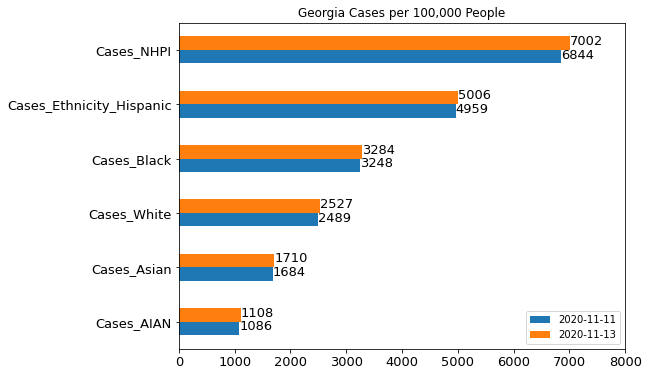

In [130]:
#2018 ACS population data
Asian_population=399223
Black_population=3195363
Hispanic_population=968463
White_population=5476441
NHPI_population=5070
AIAN_population=18416

White_cases_per_cap=pd.DataFrame((append_data['Cases_White']/White_population*100000).round()).T
Black_cases_per_cap=pd.DataFrame((append_data['Cases_Black']/Black_population*100000).round()).T
Hispanic_cases_per_cap=pd.DataFrame((append_data['Cases_Ethnicity_Hispanic']/Hispanic_population*100000).round()).T
Asian_cases_per_cap=pd.DataFrame((append_data["Cases_Asian"]/Asian_population*100000).round()).T
NHPI_cases_per_cap=pd.DataFrame((append_data["Cases_NHPI"]/NHPI_population*100000).round()).T
AIAN_cases_per_cap=pd.DataFrame((append_data["Cases_AIAN"]/AIAN_population*100000).round()).T

Cases_per_cap=pd.concat([White_cases_per_cap, Black_cases_per_cap,Hispanic_cases_per_cap,Asian_cases_per_cap,
                        NHPI_cases_per_cap,AIAN_cases_per_cap], axis=0)
Cases_per_cap=Cases_per_cap.sort_values(Cases_per_cap.columns[1],ascending=True)
ax=Cases_per_cap.plot.barh(figsize=(8, 6),title="Georgia Cases per 100,000 People",fontsize=13)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.1, \
            int((i.get_width())), fontsize=13,
color='black')

ax=ax.set_xlim(0,8000)

# Per Capita Bar Chart: Deaths per 100k people

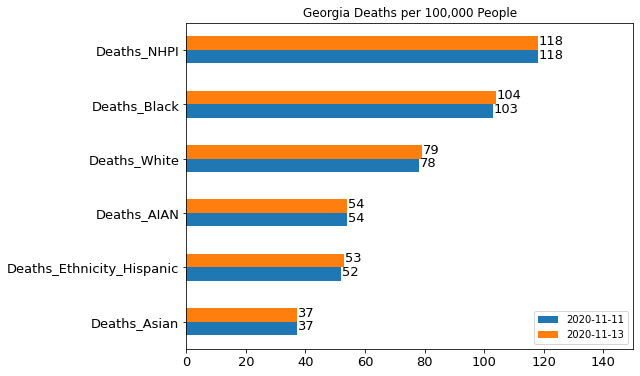

In [131]:
#2018 ACS population data
Asian_population=399223
Black_population=3195363
Hispanic_population=968463
White_population=5476441
NHPI_population=5070
AIAN_population=18416

White_deaths_per_cap=pd.DataFrame((append_data['Deaths_White']/White_population*100000).round()).T
Black_deaths_per_cap=pd.DataFrame((append_data['Deaths_Black']/Black_population*100000).round()).T
Hispanic_deaths_per_cap=pd.DataFrame((append_data['Deaths_Ethnicity_Hispanic']/Hispanic_population*100000).round()).T
Asian_deaths_per_cap=pd.DataFrame((append_data["Deaths_Asian"]/Asian_population*100000).round()).T
NHPI_deaths_per_cap=pd.DataFrame((append_data["Deaths_NHPI"]/NHPI_population*100000).round()).T
AIAN_deaths_per_cap=pd.DataFrame((append_data["Deaths_AIAN"]/AIAN_population*100000).round()).T

Deaths_per_cap=pd.concat([White_deaths_per_cap, Black_deaths_per_cap,Hispanic_deaths_per_cap,Asian_deaths_per_cap,
                        NHPI_deaths_per_cap,AIAN_deaths_per_cap], axis=0)
Deaths_per_cap=Deaths_per_cap.sort_values(Cases_per_cap.columns[1],ascending=True)
ax=Deaths_per_cap.plot.barh(figsize=(8, 6),title="Georgia Deaths per 100,000 People",fontsize=13)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.1, \
            int((i.get_width())), fontsize=13,
color='black')

ax=ax.set_xlim(0,150)

# Testing Data Visualizations for Percent of Change

<AxesSubplot:title={'center':'White vs Black Cases % Change Timeseries'}, xlabel='Date', ylabel='% Change'>

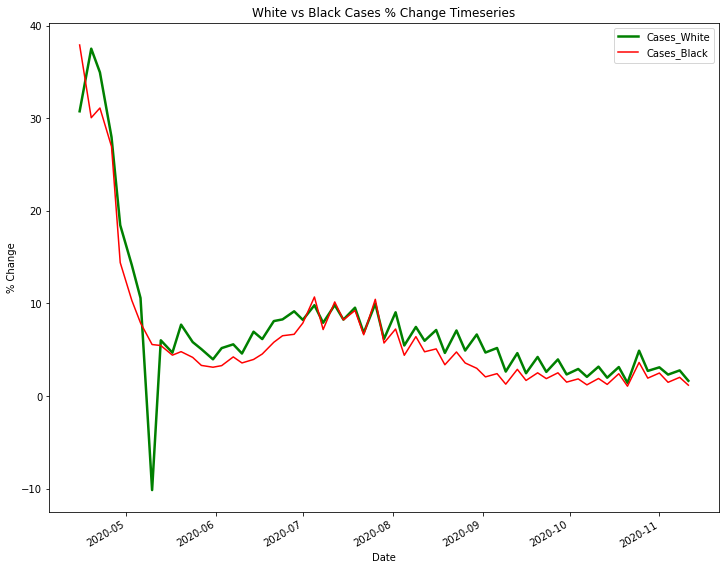

In [132]:
#Percent change for each CRDT data entry shift for White Cases vs Black Cases
cases_white = Georgia_Historical[['Date','Cases_White']].sort_values(by='Date')
cases_white.set_index('Date', inplace=True)
cases_white=cases_white.astype('float64')
cases_white_pct=cases_white.pct_change()*100

cases_black = Georgia_Historical[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

ax=cases_white_pct.plot(figsize=(12, 10), title='White vs Black Cases % Change Timeseries',linewidth=2.5, color='green'
                     ,ylabel='% Change',xlabel='Date')

cases_black_pct.plot(ax=ax, color='red')

<AxesSubplot:title={'center':'Black vs Asian Cases % Change Timeseries'}, xlabel='Date', ylabel='% Change'>

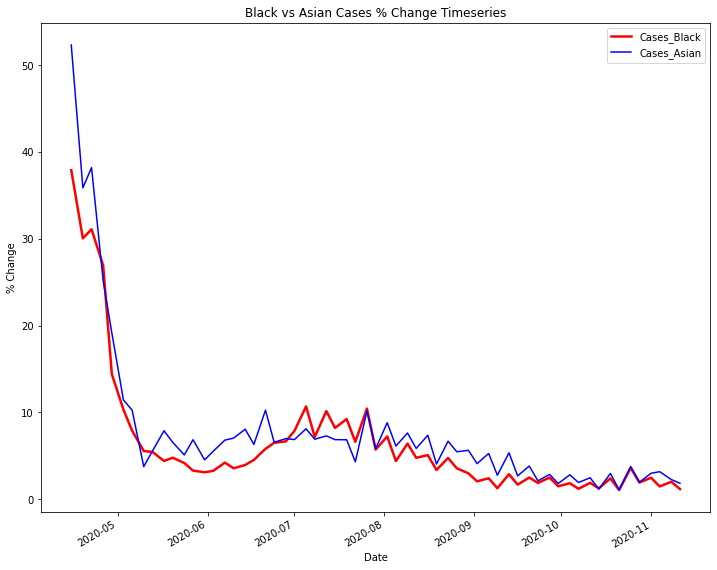

In [133]:
#Percent change for each CRDT data entry shift for Black Cases vs Asian Cases
cases_black = Georgia_Historical[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

cases_asian = Georgia_Historical[['Date','Cases_Asian']].sort_values(by='Date')
cases_asian.set_index('Date', inplace=True)
cases_asian=cases_asian.astype('float64')
cases_asian_pct=cases_asian.pct_change()*100

ax=cases_black_pct.plot(figsize=(12, 10), title='Black vs Asian Cases % Change Timeseries',linewidth=2.5, color='red'
                     ,ylabel='% Change',xlabel='Date')
cases_asian_pct.plot(ax=ax, color='blue')

# Summary Statistics for Percentage Change for Each Race and Ethnicity

In [134]:
Georgia_Historical_Sorted=Georgia_Historical.set_index('Date').sort_index()
Georgia_Historical_Sorted=Georgia_Historical_Sorted.astype('float64')
Georgia_Historical_PCT=Georgia_Historical_Sorted.pct_change()*100
Georgia_Historical_PCT.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Cases_Total,61.0,5.890316,6.838127,-13.523218,1.808149,4.412362,7.791262,41.148162
Cases_White,61.0,7.398174,7.781229,-10.149095,3.176688,5.585453,8.226430,37.504726
Cases_Black,61.0,6.362192,7.368456,1.065639,2.421964,4.229064,6.668935,37.905874
Cases_LatinX,61.0,13.478372,62.960644,0.000000,1.410329,4.045484,9.097035,494.014085
Cases_Asian,61.0,7.718913,8.951868,1.092511,3.182472,5.830040,7.306889,52.325581
Cases_AIAN,61.0,5.524871,10.758148,-21.951220,0.000000,2.777778,7.865169,47.826087
Cases_NHPI,61.0,8.474435,22.398226,-60.000000,1.587302,4.519774,12.500000,150.000000
Cases_Multiracial,61.0,inf,NaN,-100.000000,0.000000,0.000000,0.000000,inf
Cases_Other,61.0,inf,NaN,-100.000000,1.132075,3.353884,8.971368,inf
Cases_Unknown,61.0,4.147406,8.499328,-22.285546,-0.604282,1.282083,8.796170,31.417872


# Create a csv for today's scrpaer data

In [137]:
#to make the CSV based for just this scraper
new_data.to_csv(r"C:\Users\wjg39\Documents\Desktop\CRDT\GA\\"+str(new_data["Date"].loc[0].date())+"_race-ethnicity_Georgia.csv", index = False)

# Add today's scraper data to historical data

In [136]:
#to append new data to the csv of all historical
new_data.to_csv(r'C:\Users\wjg39\Documents\Desktop\CRDT\GA\historical_race-ethnicity_Georgia.csv', mode='a', header=False,index=False)

# Changing the name of the file on path to the current day 
# This closes the file and renames so only run when fully complete with scraping and data quality checks

In [74]:
import os
import datetime
#closes the zip file. 
zf.close()
Current_Date = datetime.datetime.today().strftime ('%d-%b-%Y')
os.rename(r"C:\Users\wjg39\Downloads\ga_covid_data.zip",r"C:\Users\wjg39\Downloads\ga_covid_data_" + str(Current_Date) + '.zip')

#if you get a FileNotFoundError, it is because python has already changed the name. 